In [82]:
import torch
from torch.autograd import Variable
import torch.nn as nn

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

import math

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [83]:
train_dir = '/Users/j/Documents/AI2/Bird Recognition Competition/train'
test_dir = '/Users/j/Documents/AI2/Bird Recognition Competition/val_and_test'
checkpoint_dir = '/Users/j/Documents/AI2/Bird Recognition Competition/.ipynb_checkpoints'
result_path = '/Users/j/Documents/AI2/Bird Recognition Competition/submission.csv'

(200, 2)


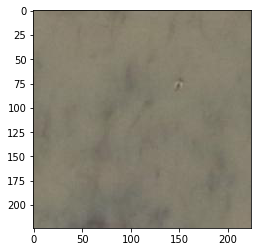

In [84]:
# The "datasets" below open your images and preprocess them
#!!!!!!!!!!!!!!!!!!!!!!!!!!!! Why normalizing !!!!!!!!!!!!!!!!!!!!!!!!!!!!#
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!! What are these !!!!!!!!!!!!!!!!!!!!!!!!!!!!#
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))

image_array = np.array(train_dataset.imgs)
print(image_array.shape)

plt.imshow(mpimg.imread(train_dataset.imgs[0][0]))

In [85]:
# The data loaders below collect your images and put them into batches to feed the neural network 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [119]:
# Define a simple CNN architecture
class Simple_CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(Simple_CNN, self).__init__()
        self.features = nn.Sequential(
#             224->55 55->27
            nn.Conv2d(3, 8, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            
            
#             nn.Conv2d(3, 8, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
            
#              nn.Conv2d(8, 8, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
            
#              nn.Conv2d(8, 8, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
            
#              nn.Conv2d(8, 8, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
            
#              nn.Conv2d(8, 8, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
            
            
#             27->23 23->11
            nn.Conv2d(8, 8, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
#             11->11 11->5
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
#             5->5
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
#         5->1
#         self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(16, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [120]:
# Define VGG
class VGG(nn.Module):

    def __init__(self, features, num_classes=2):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'L': [32, 'M', 32, 'M', 64, 64, 'M', 128, 128, 'M', 128, 128, 'M'],
}

def vgg11(**kwargs):
    """
    VGG 11-layer model (configuration "A")
    """
    model = VGG(make_layers(cfg['A']), **kwargs)
    return model

def vgg13(**kwargs):
    """
    VGG 13-layer model (configuration "B")
    """
    model = VGG(make_layers(cfg['B']), **kwargs)
    return model

def vgg16(**kwargs):
    """
    VGG 16-layer model (configuration "D")
    """
    model = VGG(make_layers(cfg['D']), **kwargs)
    return model

def vgg19(**kwargs):
    """
    VGG 19-layer model (configuration "E")
    """
    model = VGG(make_layers(cfg['E']), **kwargs)
    return model

def vggl(**kwargs):
    """
    VGGL 11-layer model (configuration "E")
    """
    model = VGG(make_layers(cfg['L']), **kwargs)
    return model

In [121]:
# Create a simple CNN
model = Simple_CNN()

# Create a ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Use cross-entropy loss
criterion = nn.CrossEntropyLoss()

In [122]:
# Create a VGGL CNN
# model = vggl()

# Create a ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Use cross-entropy loss
criterion = nn.CrossEntropyLoss()

In [123]:
def get_accuracy(output, target):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.size(0)

    _, pred = output.topk(1, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    correct_k = correct[0].view(-1).float().sum(0, keepdim=True)

    return correct_k.mul_(1.0 / batch_size).data[0]

In [124]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [125]:
def train(model, data_loader, criterion, optimizer):
    loss_recorder = AverageMeter() # record the loss of each batch to get the overall loss
    accuracy_recorder = AverageMeter() # record the accuracy of each batch to get the overall accuracy
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!! What is this !!!!!!!!!!!!!!!!!!!!!!!!!!!!#
    model.train() # switch to train mode
    for i, (input, target) in enumerate(data_loader):
        input, target = Variable(input), Variable(target)
        output = model(input)
        loss = criterion(output, target)
        
        optimizer.zero_grad() # clear the gradients computed before
        loss.backward() # compute the gradients using backward propagation
        optimizer.step() # update the parameters of the network
        
        accuracy = get_accuracy(output, target)
        loss = loss.cpu().data[0] # convert from pytorch variable to a python float number
        print('Batch {}:\tloss: {:.05f}\t accuracy: {:.05f}'.format(i+1, loss, accuracy))
        loss_recorder.update(loss, input.size(0))
        accuracy_recorder.update(accuracy, input.size(0))
    return loss_recorder.avg, accuracy_recorder.avg

In [126]:
def validate(model, data_loader, criterion):
    loss_recorder = AverageMeter() # record the loss of each batch to get the overall loss
    accuracy_recorder = AverageMeter() # record the accuracy of each batch to get the overall accuracy
    model.eval() # switch to evaluation mode
    for i, (input, target) in enumerate(data_loader):
        input, target = Variable(input, volatile=True), Variable(target)
        output = model(input)
        loss = criterion(output, target)
        
        accuracy = get_accuracy(output, target)
        loss = loss.cpu().data[0] # convert from pytorch variable to a python float number
        print('Batch {}:\tloss: {:.05f}\t accuracy: {:.05f}'.format(i+1, loss, accuracy))
        loss_recorder.update(loss, input.size(0))
        accuracy_recorder.update(accuracy, input.size(0))
    return loss_recorder.avg, accuracy_recorder.avg

In [127]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!! Why Using Checkpoint !!!!!!!!!!!!!!!!!!!!!!!!!!!!#
def save_checkpoint(state, filename):
    torch.save(state, filename)
    print('A checkpoint was saved to {}'.format(filename))

In [128]:
num_epochs = 50

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs+1):
    print('\nEpoch', epoch)
    
    print('---- train ----')
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
        
    save_checkpoint(model.state_dict(), checkpoint_dir+'/checkpoint_epoch{}.pk'.format(epoch))


Epoch 1
---- train ----


AttributeError: 'Simple_CNN' object has no attribute 'avgpool'

ValueError: x and y must have same first dimension, but have shapes (50,) and (13,)

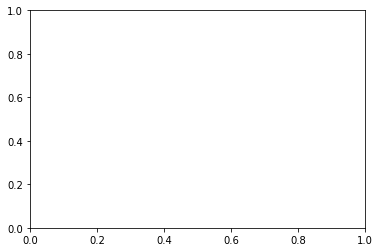

In [68]:
plt.figure()
plt.plot(np.arange(num_epochs)+1, train_losses)
#plt.plot(np.arange(num_epochs)+1, val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

ValueError: x and y must have same first dimension, but have shapes (50,) and (13,)

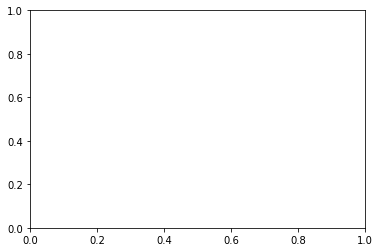

In [69]:
plt.figure()
plt.plot(np.arange(num_epochs)+1, train_accuracies)
#plt.plot(np.arange(num_epochs)+1, val_accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])

Choose a model that you like best

In [70]:
prefered_checkpoint = '/Users/j/Documents/AI2/Bird Recognition Competition/.ipynb_checkpoints/checkpoint_epoch50.pk'
model.load_state_dict(torch.load(prefered_checkpoint))

Let your AI automatically recognize if there are birds in each images in test set

In [64]:
images = []
preds = []
model.eval()
for i, (input, target) in enumerate(tqdm(test_loader)):
    input, target = Variable(input, volatile=True), Variable(target)
    output = model(input)
    confidence = nn.functional.softmax(output, dim=1)
    confidence = confidence.cpu().data[0].numpy()
    if confidence[0] >= 0.5: # If the network predicts that the image contains a bird
        pred = 1
    else:
        pred = 0
    preds.append(pred)
    
    # Get the file name of the current image
    image = test_dataset.imgs[i]
    image = os.path.basename(image[0])
    images.append(image)
submission = pd.DataFrame({'image': images, 'has_bird': preds}, columns=['image', 'has_bird'])

100%|██████████| 200/200 [00:05<00:00, 35.81it/s]


Take a look at the first rows of the result.

In [65]:
submission.head()

,image,has_bird
0,0000.JPG,1
1,0001.JPG,0
2,0002.JPG,1
3,0003.JPG,1
4,0004.JPG,0


In [66]:
submission.to_csv(result_path, index=False)